In [13]:
# Import required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split, TimeSeriesSplit
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import lightgbm as lgb
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import StackingRegressor, RandomForestRegressor
from xgboost import XGBRegressor

# Custom Metrics
def smape(y_true, y_pred):
    return 100 * np.mean(2 * np.abs(y_pred - y_true) / (np.abs(y_true) + np.abs(y_pred)))

def adjusted_mape(y_true, y_pred):
    epsilon = 1e-3
    return 100 * np.mean(np.abs((y_true - y_pred) / (y_true + epsilon)))

# Load the dataset
data = pd.read_csv("/content/Synthetic_Inventory_Management_Dataset_10years.csv")
print(data.head())


  Product_ID           Product_Name     Category  Current_Stock  \
0     P00026         Smartphone X10  Electronics             52   
1     P00259   Unisex Running Shoes     Clothing            906   
2     P00351    Smartwatch Active 3  Electronics            215   
3     P00150          Laptop Pro 15  Electronics            163   
4     P00792  Cereal Breakfast Pack         Food            268   

   Reorder_Level  Stockout_Risk  Lead_Time_Days Supplier_ID  \
0             25           0.12              11        S085   
1            188           0.79              10        S030   
2            157           0.28              25        S055   
3             38           0.18               5        S055   
4            125           0.47              13        S092   

   Supplier_Reliability  Supplier_Lead_Time  ...  Weather_Conditions  \
0                  0.74                   5  ...               Snowy   
1                  0.79                   1  ...               Sunny   
2 

In [14]:
# Ensure 'Delivery_Date' exists and is valid
if "Delivery_Date" not in data.columns or data["Delivery_Date"].isna().all():
    print("Recreating 'Delivery_Date' column.")
    data["Delivery_Date"] = pd.date_range(start="2020-01-01", periods=len(data), freq="D")
else:
    data["Delivery_Date"] = pd.to_datetime(data["Delivery_Date"], errors="coerce")

# Log-transform the target variable to stabilize variance
data["Historical_Demand"] = np.log1p(data["Historical_Demand"])


In [15]:
# Feature Engineering
data.drop_duplicates(inplace=True)
data.fillna(method="ffill", inplace=True)

# Lagged Features
lag_steps = [3, 7, 14]
for lag in lag_steps:
    data[f"Historical_Demand_Lag_{lag}"] = data["Historical_Demand"].shift(lag)

# Rolling Features
rolling_windows = [3, 7]
for window in rolling_windows:
    data[f"Historical_Demand_Rolling_Mean_{window}"] = data["Historical_Demand"].rolling(window=window).mean()
    data[f"Historical_Demand_Rolling_Std_{window}"] = data["Historical_Demand"].rolling(window=window).std()

# Additional Features
data["Historical_Demand_EWA"] = data["Historical_Demand"].ewm(span=5).mean()
data["Day"] = data["Delivery_Date"].dt.day
data["Month"] = data["Delivery_Date"].dt.month
data["Year"] = data["Delivery_Date"].dt.year
data["Day_of_Week"] = data["Delivery_Date"].dt.dayofweek
data["Week_of_Year"] = data["Delivery_Date"].dt.isocalendar().week

# Interaction and Cumulative Features
data["Lag_Diff_3"] = data["Historical_Demand_Lag_3"] - data["Historical_Demand_Lag_7"]
data["Lag_Interaction"] = data["Historical_Demand_Lag_3"] * data["Historical_Demand_Rolling_Mean_3"]
data["Cumulative_Sum"] = data["Historical_Demand"].cumsum()

# Drop rows with NaN values introduced by lagging or rolling
data.dropna(inplace=True)

# Normalize Numerical Features
scaler = MinMaxScaler()
columns_to_scale = data.select_dtypes(include=[np.number]).columns
data[columns_to_scale] = scaler.fit_transform(data[columns_to_scale])

# Select Features and Target
features = [col for col in data.columns if col not in ["Delivery_Date", "Historical_Demand"]]
target = "Historical_Demand"

X = data[features]
y = data[target]


<ipython-input-15-e160e716d2a6>:3: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  data.fillna(method="ffill", inplace=True)


In [16]:
# Identify non-numeric columns
non_numeric_columns = X.select_dtypes(include=['object']).columns
print(f"Non-numeric columns: {non_numeric_columns}")

# Drop non-numeric columns (like 'P00893') for PCA
X_numeric = X.drop(columns=non_numeric_columns)

# Check to ensure all features are numeric
print("Columns used for PCA:")
print(X_numeric.dtypes)

# Apply Scaling and PCA
# Save original columns used for scaling
# Save original column names used for scaling
original_scaling_columns = X_numeric.columns  # Save feature names
print("Features Used for Scaling:")
print(original_scaling_columns)


# Scale the training data
scaler_pca = StandardScaler()
X_scaled = scaler_pca.fit_transform(X_numeric)

# Apply PCA
pca = PCA(n_components=0.95)  # Retain 95% variance
X_pca = pca.fit_transform(X_scaled)


print(f"Shape after PCA: {X_pca.shape}")


Non-numeric columns: Index(['Product_ID', 'Product_Name', 'Category', 'Supplier_ID',
       'Delivery_Status', 'Weather_Conditions', 'Timestamp'],
      dtype='object')
Columns used for PCA:
Current_Stock                       float64
Reorder_Level                       float64
Stockout_Risk                       float64
Lead_Time_Days                      float64
Supplier_Reliability                float64
Supplier_Lead_Time                  float64
Forecasted_Demand                   float64
Seasonality_Index                   float64
Delay_Days                          float64
Economic_Indicators                 float64
Holiday_Flag                        float64
Order_Frequency                     float64
Batch_Size                          float64
Inventory_Turnover                  float64
Safety_Stock_Level                  float64
Dead_Stock                          float64
Damaged_Stock                       float64
Historical_Demand_Lag_3             float64
Historical_Demand

In [17]:
# Use a subset of the data for hyperparameter tuning
subset_data = data.iloc[:1000]  # First 1000 rows
y_subset = subset_data["Historical_Demand"]
X_subset = X_pca[:1000]

# Define Hyperparameter Grid
param_grid = {
    'n_estimators': [600, 800],
    'learning_rate': [0.005, 0.01],
    'max_depth': [10, 12],
    'num_leaves': [40, 50],
    'min_child_samples': [20, 30],
    'subsample': [0.7, 0.8],
    'colsample_bytree': [0.7, 0.8],
    'reg_alpha': [0.1],
    'reg_lambda': [0.1],
}

# Grid Search with TimeSeriesSplit
tscv = TimeSeriesSplit(n_splits=5)
lgbm_regressor = lgb.LGBMRegressor(random_state=42)
grid_search_lgbm = GridSearchCV(
    estimator=lgbm_regressor,
    param_grid=param_grid,
    cv=tscv,
    scoring='neg_mean_squared_error',
    verbose=2,
    n_jobs=-1
)

print("Starting Grid Search...")
grid_search_lgbm.fit(X_subset, y_subset)
print("Best Parameters:", grid_search_lgbm.best_params_)


Starting Grid Search...
Fitting 5 folds for each of 128 candidates, totalling 640 fits


/usr/local/lib/python3.10/dist-packages/sklearn/utils/_tags.py:354: FutureWarning: The LGBMRegressor or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.OutlierMixin`. From scikit-learn 1.7, not defining `__sklearn_tags__` will raise an error.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000312 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6120
[LightGBM] [Info] Number of data points in the train set: 1000, number of used features: 24
[LightGBM] [Info] Start training from score 0.693588
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, 

In [18]:
# Train the model on the full dataset with best parameters
X_train_full, X_test_full, y_train_full, y_test_full = train_test_split(
    X_pca, y, test_size=0.2, random_state=42, shuffle=False
)

best_lgbm_regressor = lgb.LGBMRegressor(**grid_search_lgbm.best_params_, random_state=42)
best_lgbm_regressor.fit(X_train_full, y_train_full)

# Predict
y_pred_lgbm_full = best_lgbm_regressor.predict(X_test_full)

# Reverse log transformation for evaluation
y_pred_lgbm_full = np.expm1(y_pred_lgbm_full)
y_test_full = np.expm1(y_test_full)

# Clip small values in the target variable to reduce Adjusted MAPE sensitivity
epsilon = 1e-2
y_test_full = np.maximum(y_test_full, epsilon)
y_pred_lgbm_full = np.maximum(y_pred_lgbm_full, epsilon)

# Evaluate the Model
rmse = np.sqrt(mean_squared_error(y_test_full, y_pred_lgbm_full))
mae = mean_absolute_error(y_test_full, y_pred_lgbm_full)
smape_score = smape(y_test_full, y_pred_lgbm_full)
mape_score = adjusted_mape(y_test_full, y_pred_lgbm_full)
r2 = r2_score(y_test_full, y_pred_lgbm_full)

print("\nLightGBM Model Evaluation Metrics on Full Dataset:")
print(f"RMSE: {rmse:.4f}")
print(f"MAE: {mae:.4f}")
print(f"SMAPE: {smape_score:.2f}%")
print(f"Adjusted MAPE: {mape_score:.2f}%")
print(f"R^2 Score: {r2:.4f}")


/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.017978 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6120
[LightGBM] [Info] Number of data points in the train set: 79988, number of used features: 24
[LightGBM] [Info] Start training from score 0.699730


/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(



LightGBM Model Evaluation Metrics on Full Dataset:
RMSE: 0.3465
MAE: 0.2790
SMAPE: 33.07%
Adjusted MAPE: 74.80%
R^2 Score: 0.4235


/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
<ipython-input-25-ce3c5517850d>:40: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  future_data.fillna(0, inplace=True)
/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
<ipython-input-25-ce3c5517850d>:40: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_

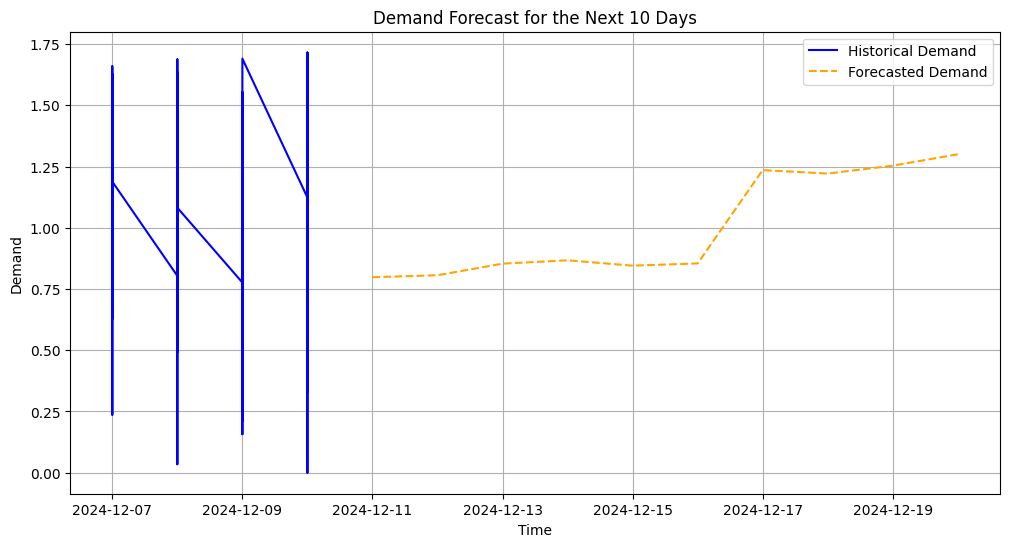

In [25]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Define the number of days to forecast
forecast_days = 10

# Initialize a DataFrame for forecasting
future_data = data.tail(1).copy()  # Start from the last row of the dataset
# Forecasting
future_predictions = []

# Loop for the number of forecast days
for i in range(forecast_days):
    # Generate lag features for the next day
    for lag in [3, 7, 14]:
        future_data[f"Historical_Demand_Lag_{lag}"] = future_data["Historical_Demand"].shift(lag)

    # Rolling statistics
    for window in [3, 7]:
        future_data[f"Historical_Demand_Rolling_Mean_{window}"] = future_data["Historical_Demand"].rolling(window=window).mean()
        future_data[f"Historical_Demand_Rolling_Std_{window}"] = future_data["Historical_Demand"].rolling(window=window).std()

    # Additional features
    future_data["Historical_Demand_EWA"] = future_data["Historical_Demand"].ewm(span=5).mean()
    future_data["Lag_Diff_3"] = future_data["Historical_Demand_Lag_3"] - future_data["Historical_Demand_Lag_7"]
    future_data["Lag_Interaction"] = future_data["Historical_Demand_Lag_3"] * future_data["Historical_Demand_Rolling_Mean_3"]
    future_data["Cumulative_Sum"] = future_data["Historical_Demand"].cumsum()

    # Handle temporal features for the next day
    next_date = future_data["Delivery_Date"].iloc[-1] + pd.Timedelta(days=1)
    future_data["Day"] = next_date.day
    future_data["Month"] = next_date.month
    future_data["Year"] = next_date.year
    future_data["Day_of_Week"] = next_date.dayofweek
    future_data["Week_of_Year"] = next_date.isocalendar().week

    # Impute any remaining NaN values
    # Fill missing lag and rolling features with 0 (or other suitable default values)
    future_data.fillna(0, inplace=True)

    # Select only columns that match the training data
    X_future = future_data[original_scaling_columns].tail(1)

    # Apply scaler and PCA transformations
    X_future_scaled = scaler_pca.transform(X_future)
    X_future_pca = pca.transform(X_future_scaled)

    # Forecast using the trained LightGBM model
    y_forecast = best_lgbm_regressor.predict(X_future_pca)
    y_forecast = np.expm1(y_forecast)  # Reverse log transformation
    future_predictions.append(y_forecast[0])

    # Append the forecasted value for the next iteration
    future_data = pd.concat(
        [future_data, pd.DataFrame({"Delivery_Date": [next_date], "Historical_Demand": [np.log1p(y_forecast)]})],
        ignore_index=True
    )

# Create a DataFrame for the forecasted values
forecast_dates = pd.date_range(start=data["Delivery_Date"].iloc[-1] + pd.Timedelta(days=1), periods=forecast_days)
forecast_df = pd.DataFrame({"Delivery_Date": forecast_dates, "Forecasted_Demand": future_predictions})

# Plot the forecast
plt.figure(figsize=(12, 6))
plt.plot(data["Delivery_Date"].tail(100), np.expm1(data["Historical_Demand"].tail(100)), label="Historical Demand", color="blue")
plt.plot(forecast_df["Delivery_Date"], forecast_df["Forecasted_Demand"], label="Forecasted Demand", color="orange", linestyle="--")
plt.xlabel("Time")
plt.ylabel("Demand")
plt.title("Demand Forecast for the Next 10 Days")
plt.legend()
plt.grid()
plt.show()
